<a href="https://colab.research.google.com/github/john-reilly/RoboFarm/blob/master/Apples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#!ls

#!ls  '/content/gdrive/My Drive/'
base_dir = '/content/gdrive/My Drive/'

In [0]:
import os
import random
import time

import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps
#import rospy #not going to be using ROS for this

class ObjectClassifier:

    def __init__(self):
        # constants
        self.OBJECT_DETECTION_TRAFFIC_LIGHT_CLASS = 53#10 from COCO dataset
        self.DETECTION_THRESHOLD = 0.5  ##80% fine for single apple image but score s on appleing in vidoe frame mych lower0.8# 0.8#0.3

        # init object classifier (step 1)
        #cwd = os.path.dirname(os.path.realpath(__file__)) #it does n't like __file__ maybe becuase not imported?
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            try:
                with tf.gfile.GFile( base_dir + 'frozen_inference_graph.pb', 'rb') as fid:#cwd + '/models/frozen_inference_graph.pb', 'rb') as fid:
                    serialized_graph = fid.read()
                    od_graph_def.ParseFromString(serialized_graph)
                    tf.import_graph_def(od_graph_def, name='')
                    self.session = tf.Session(graph=self.detection_graph)
            except Exception as e:
                print(e)
                exit()

    def get_traffic_light_images(self, image):
        output_dict = self.run_inference_for_single_image(image)
        return self.extract_image_from_boxes(image, output_dict)

    def run_inference_for_single_image(self, image):
        # Get handles to input and output tensors
        ops = self.detection_graph.get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
            'num_detections', 'detection_boxes', 'detection_scores', 'detection_classes'
        ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = self.detection_graph.get_tensor_by_name(
                    tensor_name)
        image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')

        # Run inference
        start = time.time()
        output_dict = self.session.run(tensor_dict,
                               feed_dict={image_tensor: np.expand_dims(image, 0)})
        elapsed = time.time() - start
        print('inference took:', elapsed, ' seconds') #was commented out
        
        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        #john
        print("num_detections:" , output_dict['num_detections'])#john
        output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
        #john
        print(output_dict['detection_classes'])
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]
        #
        #print(" output_dict['detection_boxes']  " , output_dict['detection_boxes'])
        print(" output_dict['detection_scores'] " , output_dict['detection_scores'])

        return output_dict

    def extract_image_from_boxes(self, image, output_dict):
        classes = output_dict['detection_classes']
        boxes = output_dict['detection_boxes']
        scores = output_dict['detection_scores']

        height, width, _ = image.shape

        tf_boxes = []
        output_images = []
        for i in range(len(boxes)):
            confidence = float(scores[i])
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            ymin = int(ymin * height)
            ymax = int(ymax * height)
            xmin = int(xmin * width)
            xmax = int(xmax * width)
            box_width = xmax - xmin
            box_height = ymax - ymin
            box_ratio = float(box_height) / box_width # ration maybe the problem
            if confidence >= self.DETECTION_THRESHOLD and \
               classes[i] == self.OBJECT_DETECTION_TRAFFIC_LIGHT_CLASS :#and \
               #box_width > 21 and \
               #box_height > 20 : # and \
               #box_ratio > 1.5:
                tf_boxes.append(boxes[i])
                #rospy.loginfo('Bouding box detected: {} {} {} {}'.format(xmin, xmax, ymin, ymax)) #not using rospy
                #
                # extract cropped image from bounding box
                #
                crop_image = image[ymin:ymax, xmin:xmax]
                crop_output_image = Image.fromarray(crop_image)
                output_images.append(crop_output_image)

        print('Outputimages len:' , len(output_images))
        return output_images


In [5]:
import os
import time
import calendar

import tensorflow as tf
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from PIL import Image, ImageOps
import numpy as np

import cv2

#from object_classifier import 
#commeted out becuase I am not useing above as a separate file
#from color_classifier import ColorClassifier
#from traffic_light_colors import TrafficLight #had isseus around the emun import so useing styx.msg below
#from styx_msgs.msg import TrafficLight #not usine
#import rospy #not using

class TLClassifier(object):
    #john  added boolean is_site to indicate site or sim classifer to load
    def __init__(self, is_site): 
        # init object classifier (step 1)
        #rospy.loginfo('TLClassifier start inititialization')
        self.object_classifier = ObjectClassifier()

        # init traffic light color classifier (step 2)
        #john added is_site log output 
        #if is_site:
        #    rospy.loginfo('is_site TRUE using site classifer')
        #else :
        #    rospy.loginfo('is_site FALSE using sim classifer')
            
        #self.color_classifier = ColorClassifier(is_site)#john ...now sending boolena to color classifier
        
        #rospy.loginfo('TLClassifier inititialized')

        self.RECORD_CROPPED_IMAGES = True#False

    def get_classification(self, image):
        """Determines the color of the traffic light in the image
        Args:
            image (cv::Mat): image containing the traffic light
        Returns:
            int: ID of traffic light color (specified in styx_msgs/TrafficLight)
        """
        #rospy.loginfo('TLClassifier received image')

        # convert from bgr 2 rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # step 1
        traffic_light_images = self.object_classifier.get_traffic_light_images(image)
        
        #traffic_light_color = self.color_classifier.predict_images(traffic_light_images)

        #tf_color = ['RED', 'YELLOW', 'GREEN', 'UNDEFINED', 'UNKNOWN'] # Not so nice ;-( but want to show text
        #rospy.loginfo('Traffic light detected {}'.format(tf_color[traffic_light_color]))

        if self.RECORD_CROPPED_IMAGES:
            dir = base_dir + '/data/cropped/'
            if not os.path.exists(dir):
                os.makedirs(dir)

            for idx, image in enumerate(traffic_light_images):
                #f_name = "sim_tl_{}_{}_{}.jpg".format(calendar.timegm(time.gmtime()), tf_color[traffic_light_color], idx)
                f_name =  "detected_cropped_{}_{}.JPG".format(calendar.timegm(time.gmtime()), idx)
                image.save(dir + f_name)

        #return traffic_light_color
        return

Using TensorFlow backend.


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3883008/45929032 bytes (8.5%)7913472/45929032 bytes (17.2%)11984896/45929032 bytes (26.1%)16195584/45929032 bytes (35.3%)20373504/45929032 bytes (44.4%)24584192/45929032 bytes (53.5%)28827648/45929032 bytes (62.8%)33038336/45929032 bytes (71.9%)37134336/45929032 bytes (80.9%)41336832/45929032 bytes (90.0%)45441024/45929032 bytes (98.9%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

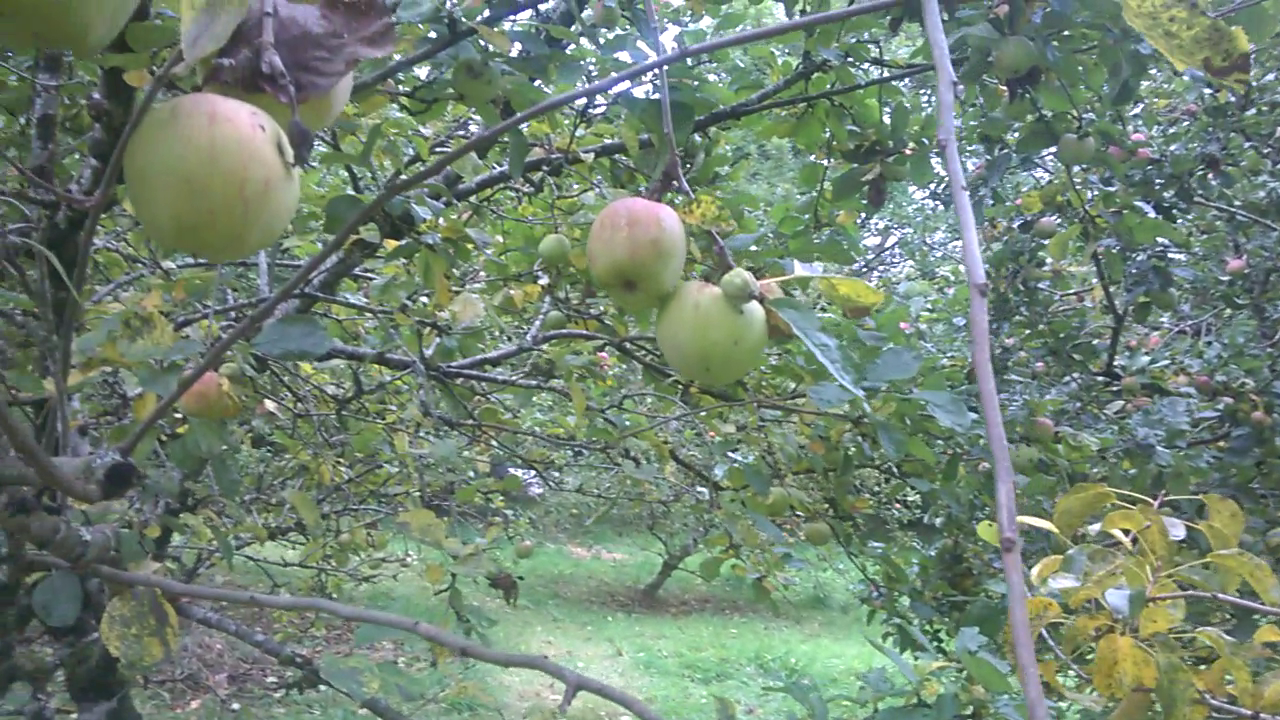

inference took: 3.476736545562744  seconds
num_detections: 100
[53 53 53 53 53 53 53 53 53 53 53 53 53 53 55 53 53 56 53 16 53 37 53 53
 37 53 53 56 53 56 53 56 53 56 56 56 53 56 53 53 53 56 53 56 56 56 56 56
 56 53 56 56 56 56 53 56 56 53 56 53 56 56 56 56 53 56 53 56 56 56 56 56
 56 56 56 53 56 56 56 56 53 56 56 56 53 53 53 56 53 56 53 56 56 56 56 53
 56 56 56 56]
 output_dict['detection_scores']  [0.9486543  0.36964118 0.23162872 0.22308162 0.19798157 0.19271055
 0.13437158 0.12559202 0.11918971 0.11855003 0.11543727 0.10813445
 0.10616213 0.10538718 0.0977281  0.09762129 0.09584737 0.0925009
 0.09211206 0.08816451 0.08651966 0.08648583 0.08639628 0.08523253
 0.08368209 0.08155513 0.08137435 0.08126152 0.08096552 0.07818016
 0.07725859 0.07651231 0.07630458 0.07622981 0.07616314 0.07542837
 0.07515967 0.07393935 0.07013512 0.06993729 0.069534   0.06897652
 0.06857097 0.06788659 0.06781188 0.06776893 0.06733987 0.06654024
 0.06597689 0.06580704 0.06577411 0.06576103 0.06522864 0.0650

In [6]:
#self.light_classifier = TLClassifier(self.is_site)

is_site = True
light_classifier = TLClassifier(is_site)

image = cv2.imread(base_dir+'APPLE.JPG')

from google.colab.patches import cv2_imshow
#cv2_imshow( image)

#light_classifier.get_classification(image)

from moviepy.editor import VideoFileClip
from IPython.display import HTML #from my lane line project

clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4')

#clip1.fl_image(light_classifier.get_classification()) 

frame = clip1.get_frame(19)

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


cv2_imshow( frame)

light_classifier.get_classification(frame)